# Bicycle-stations Availability Prediction

Use a supervised machine learning algorithm to predict the availability for each bicyle-sharing stations in Lyon (France) based on the history data.

I use the tree method [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) to predict a "probability" of bikes availability for each station. A number close to 1. means that you have several available bikes. A number close to 0. means you don't have many bikes.

## Some Imports

In [1]:
%matplotlib inline

In [32]:
import numpy as np
import pandas as pd

In [157]:
from xgboost import plot_tree

In [93]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
import folium

In [4]:
%load_ext watermark

In [25]:
%watermark -d -v -p numpy,pandas,xgboost,matplotlib,folium -g -m -w

2017-10-18 

CPython 3.6.0
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
xgboost 0.6
matplotlib 2.0.2
folium 0.5.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.14.32-xxxx-grs-ipv6-64
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
Git hash   : ef09bd9b3b80cdae405e6b89b53cb78e2e5ad86a
watermark 1.5.0


The module `prediction.py` contains some functions dedicated to the bicyle-sharing stations predictions.

In [7]:
from prediction import (datareader, complete_data, cleanup, bikes_probability,
                        time_resampling, prepare_data_for_training, fit, prediction)

## Read and prepare the data

In [8]:
DATAFILE = './data/lyon.csv'

In [9]:
raw = datareader(DATAFILE)

2017-10-18 11:09:17,887 [17493] INFO     prediction: read the file './data/lyon.csv'


In [10]:
raw.head()

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
0,10063,2017-07-08 23:49:09,34,10,23,1,Vert,Non,OPEN
1,10021,2017-07-08 00:30:12,19,0,0,0,Gris,Non,CLOSED
2,8038,2017-07-08 23:49:26,20,6,14,1,Vert,Non,OPEN
3,7045,2017-07-08 23:52:43,20,13,7,1,Vert,Non,OPEN
4,6045,2017-07-08 23:52:14,15,7,8,1,Vert,Non,OPEN


Min and max dates of the timeseries

In [11]:
print(raw.last_update.min())
print(raw.last_update.max())

2017-07-08 00:30:12
2017-09-26 14:58:46


Clean up some columns : drop some lines with the 'CLOSED' status, drop duplicates, remove missing values, etc.

In [12]:
df_clean = cleanup(raw)

2017-10-18 11:11:52,855 [17493] INFO     prediction: cleanup processing


Pipe some processing data functions :

* time resampling to get data every 10 minutes (i.e. `10T`)
* add some columns : day of the week, hour of the day, etc.
* compute the bikes (number) "probability". It's just a normalization for each station with `num_avail_bikes / total`

In [13]:
df = (df_clean.pipe(time_resampling)
      .pipe(complete_data)
      .pipe(bikes_probability))

2017-10-18 11:12:31,938 [17493] INFO     prediction: Time resampling for each station by '10T'
2017-10-18 11:12:34,788 [17493] INFO     prediction: complete some data
2017-10-18 11:13:10,124 [17493] INFO     prediction: bikes probability


In [14]:
df.head()

,station,ts,bikes,stands,day,hour,minute,probability
0,1001,2017-07-09 00:00:00,15.0,1.0,6,0,0,0.93750
1,1001,2017-07-09 00:10:00,15.0,1.0,6,0,0,0.93750
2,1001,2017-07-09 00:20:00,14.5,1.5,6,0,10,0.90625
3,1001,2017-07-09 00:30:00,14.5,1.5,6,0,20,0.90625
4,1001,2017-07-09 00:40:00,11.5,4.5,6,0,30,0.71875


This is the final dataset. For further prediction, I could add some weather forecasts data to these features.

## Prediction

Let's select a time window (start, stop) to a single prediction.

* Two weeks of data for training
* Predict the 'probability' for the next 30 minutes and 1 hour for every station.
* Split the dataset into train and test dataset
* Compute the RMSE (Root Mean Squared Error) between the observations (i.e. probability) and the predicted values

In [21]:
start = pd.Timestamp("2017-07-11T00:00:00") # Tuesday
predict_date = pd.Timestamp("2017-07-26T10:00:00") # wednesday
# predict the next 30 minutes
freq = '30T'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
periods = 2

In [22]:
train_X, train_Y, test_X, test_Y = prepare_data_for_training(df,
                                                             predict_date,
                                                             freq=freq,
                                                             start=start,
                                                             periods=periods,
                                                             observation='probability')

2017-10-18 11:31:14,652 [17493] INFO     prediction: prepare data for training
2017-10-18 11:31:14,654 [17493] INFO     prediction: sort values (station, ts)
2017-10-18 11:31:15,958 [17493] INFO     prediction: compute the future availability at '30T'
2017-10-18 11:31:16,315 [17493] INFO     prediction: merge data with the future availability
2017-10-18 11:31:50,695 [17493] INFO     prediction: availability label as values
2017-10-18 11:31:51,094 [17493] INFO     prediction: cut date 2017-07-26 09:30:00
2017-10-18 11:31:51,095 [17493] INFO     prediction: stop date 2017-07-26 11:00:00
2017-10-18 11:31:51,096 [17493] INFO     prediction: split train and test according to a prediction date


In [23]:
train_X.head()

,station,bikes,stands,day,hour,minute
ts,,,,,,
2017-07-11,1001,12.0,1.0,1,0,0
2017-07-11,1002,6.0,15.5,1,0,0
2017-07-11,1003,14.0,1.0,1,0,0
2017-07-11,1005,1.0,9.0,1,0,0
2017-07-11,1006,4.5,17.5,1,0,0


In [24]:
# Observation with a shift of T+30 minutes in comparison to train_X.
# This is the 'future' availability used for traning.
train_Y.head()

ts
2017-07-11    0.923077
2017-07-11    0.295455
2017-07-11    0.933333
2017-07-11    0.100000
2017-07-11    0.227273
Name: future, dtype: float64

In [28]:
train_X.iloc[3200:3210]

,station,bikes,stands,day,hour,minute
ts,,,,,,
2017-07-11 01:30:00,7022,12.0,17.0,1,1,20
2017-07-11 01:30:00,7023,12.5,1.5,1,1,20
2017-07-11 01:30:00,7024,5.0,11.0,1,1,20
2017-07-11 01:30:00,7030,10.0,19.0,1,1,20
2017-07-11 01:30:00,7031,15.0,5.0,1,1,20
2017-07-11 01:30:00,7033,10.0,18.0,1,1,20
2017-07-11 01:30:00,7034,9.0,6.0,1,1,20
2017-07-11 01:30:00,7035,17.0,12.0,1,1,20
2017-07-11 01:30:00,7038,11.0,2.0,1,1,20


The `fit` function create some data structure for the XGBoost from the train and test DataFrames (i.e. `xgb.DMatrix)`, configure the model and launch it with the `objective: 'reg:logistic'`. It's a regression, not a classification.

In [30]:
# the 'booster'
bst = fit(train_X, train_Y, test_X, test_Y)

2017-10-18 11:36:26,820 [17493] INFO     prediction: fit


[0]	train-rmse:0.270776	test-rmse:0.268568
[1]	train-rmse:0.225618	test-rmse:0.223802
[2]	train-rmse:0.190967	test-rmse:0.189405
[3]	train-rmse:0.164578	test-rmse:0.163102
[4]	train-rmse:0.144765	test-rmse:0.143265
[5]	train-rmse:0.130189	test-rmse:0.128437
[6]	train-rmse:0.119687	test-rmse:0.117735
[7]	train-rmse:0.112251	test-rmse:0.110114
[8]	train-rmse:0.10707	test-rmse:0.104776
[9]	train-rmse:0.103513	test-rmse:0.101137
[10]	train-rmse:0.101105	test-rmse:0.098539
[11]	train-rmse:0.099469	test-rmse:0.096903
[12]	train-rmse:0.098367	test-rmse:0.095646
[13]	train-rmse:0.097618	test-rmse:0.094834
[14]	train-rmse:0.097077	test-rmse:0.094302
[15]	train-rmse:0.096731	test-rmse:0.093938
[16]	train-rmse:0.096451	test-rmse:0.093531
[17]	train-rmse:0.09623	test-rmse:0.093313
[18]	train-rmse:0.096052	test-rmse:0.093146
[19]	train-rmse:0.095933	test-rmse:0.093115
[20]	train-rmse:0.095802	test-rmse:0.09304
[21]	train-rmse:0.095664	test-rmse:0.092992
[22]	train-rmse:0.095555	test-rmse:0.092876
[

In [31]:
# compute the prediction from test_*
pred = prediction(bst, test_X, test_Y)

In [34]:
pred[:5]

array([ 0.14073603,  0.35851732,  0.14599429,  0.22701427,  0.10939126], dtype=float32)

In [37]:
print("Number of predictions: {}".format(len(pred)))

Number of predictions: 2359


In [33]:
# Compute the RMSE
rmse = np.sqrt(np.mean((pred - test_Y)**2))
rmse

0.092800839182041447

In [159]:
# must install graphviz
# plot_tree(bst)

## Store the results

In [35]:
result = test_X.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)

result['observation'] = test_Y.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)
result['prediction'] = pred
result['error'] = pred - test_Y
result['relative_error'] = 100. * np.abs(pred - test_Y) / test_Y
result['quad_error'] = (pred - test_Y)**2
result.to_csv("prediction-freq-{}-{}.csv".format(freq, predict_date))

In [36]:
result.head(10)

,station,bikes,stands,day,hour,minute,ts_future,observation,prediction,error,relative_error,quad_error
ts,,,,,,,,,,,,
2017-07-26 10:00:00,1001,2.0,14.0,2,10,0,2017-07-26 10:30:00,0.375000,0.140736,-0.234264,62.470392,0.054880
2017-07-26 10:00:00,1002,8.0,14.0,2,10,0,2017-07-26 10:30:00,0.255814,0.358517,0.102703,40.147679,0.010548
2017-07-26 10:00:00,1003,2.0,13.0,2,10,0,2017-07-26 10:30:00,0.133333,0.145994,0.012661,9.495718,0.000160
2017-07-26 10:00:00,1005,2.0,8.0,2,10,0,2017-07-26 10:30:00,0.300000,0.227014,-0.072986,24.328576,0.005327
2017-07-26 10:00:00,1006,2.0,19.0,2,10,0,2017-07-26 10:30:00,0.047619,0.109391,0.061772,129.721656,0.003816
2017-07-26 10:00:00,1012,16.0,4.0,2,10,0,2017-07-26 10:30:00,0.850000,0.782759,-0.067241,7.910733,0.004521
2017-07-26 10:00:00,1013,3.0,8.0,2,10,0,2017-07-26 10:30:00,0.181818,0.282898,0.101080,55.593921,0.010217
2017-07-26 10:00:00,1016,2.0,15.0,2,10,0,2017-07-26 10:30:00,0.147059,0.133801,-0.013258,9.015169,0.000176
2017-07-26 10:00:00,1020,1.0,17.0,2,10,0,2017-07-26 10:30:00,0.055556,0.079889,0.024333,43.799716,0.000592


## Some maps

CSV file with station coordinates

In [68]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [69]:
locations.shape

(348, 4)

Some stations were removed when the data were cleaned up. Remove them from the location data.

In [73]:
mask = locations['idstation'].isin(result.station.unique())

In [74]:
mask.sum()

337

In [75]:
locations = locations[mask]

In [76]:
locations = locations.rename_axis({'idstation': 'station'}, axis=1)

In [77]:
locations.head()

,station,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


Some station names contains the `'` character. Replace it by the HTML code for folium.

In [78]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

Select the prediction data for a specific timestamp

In [79]:
data_to_plot = result.loc[predict_date]

In [80]:
data_to_plot.shape

(337, 12)

In [81]:
data_to_plot.head()

,station,bikes,stands,day,hour,minute,ts_future,observation,prediction,error,relative_error,quad_error
ts,,,,,,,,,,,,
2017-07-26 10:00:00,1001,2.0,14.0,2,10,0,2017-07-26 10:30:00,0.375000,0.140736,-0.234264,62.470392,0.054880
2017-07-26 10:00:00,1002,8.0,14.0,2,10,0,2017-07-26 10:30:00,0.255814,0.358517,0.102703,40.147679,0.010548
2017-07-26 10:00:00,1003,2.0,13.0,2,10,0,2017-07-26 10:30:00,0.133333,0.145994,0.012661,9.495718,0.000160
2017-07-26 10:00:00,1005,2.0,8.0,2,10,0,2017-07-26 10:30:00,0.300000,0.227014,-0.072986,24.328576,0.005327
2017-07-26 10:00:00,1006,2.0,19.0,2,10,0,2017-07-26 10:30:00,0.047619,0.109391,0.061772,129.721656,0.003816


In [83]:
yhat = data_to_plot[['station', 'prediction']].merge(locations, on='station')
yhat.head()

,station,prediction,nom,lat,lon
0,1001,0.140736,Terreaux / Terme,45.767735,4.832135
1,1002,0.358517,Opéra,45.767507,4.836282
2,1003,0.145994,Place Sathonay,45.769266,4.830080
3,1005,0.227014,Meissonier,45.766089,4.832890
4,1006,0.109391,Subsistances,45.767896,4.819817


In [104]:
y = data_to_plot[['station', 'observation']].merge(locations, on='station')

In [140]:
error = data_to_plot[['station', 'error']].merge(locations, on='station')

In [122]:
colormap = 'RdYlBu'
cmap = plt.get_cmap(colormap)

See 

* https://matplotlib.org/examples/color/colormaps_reference.html
* https://matplotlib.org/api/colors_api.html

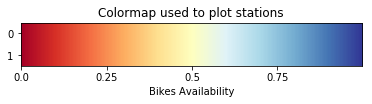

In [137]:
# show the colormap use to plot the stations, values [0, 1]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1)
fig.subplots_adjust(top=0.95, bottom=0.80, left=0.2, right=0.99)
ax.set_xticks([0., 64, 128, 192, 256])
ax.set_xticklabels([0., 0.25, 0.5, 0.75, 1.])
ax.set_xlabel('Bikes Availability')
ax.imshow(gradient, aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.title('Colormap used to plot stations')

* Red stations if there are 0 or a few available bikes
* Blue stations if there are several available bikes

In [95]:
color = lambda x: mpl.colors.to_hex(cmap(x))

In [89]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [106]:
mp_pred = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [107]:
# Map of the predicted values
for _,row in yhat.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['prediction']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['prediction'])
    ).add_to(mp_pred)

In [102]:
mp_pred

In [108]:
# Map for the observation
mp_obs = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [109]:
# Map of the observations
for _,row in y.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['observation']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['observation'])
    ).add_to(mp_obs)

In [138]:
mp_obs

In [153]:
# Colormap for error (by default, the color map fits for [0, 1] values)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
color_error = lambda x: mpl.colors.to_hex(cmap(norm(x)))

In [154]:
# Map for the errors
mp_error = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [155]:
# Map of the errors
for _,row in error.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color_error(row['error']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color_error(row['error'])
    ).add_to(mp_error)

In [156]:
mp_error